In [217]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb

from sklearn.datasets import load_boston

In [1]:
GOAL = ['target']
FEATURES = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
            'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
CATEGORICAL_FEATURES = [] 
# K-Means cannot handle categorical variables as it is distance based
# https://www.kaggle.com/general/19741

In [8]:
def run_load_data():
    print ('load_data - START')
    breast_cancer = load_boston()
    data = pd.DataFrame(data= breast_cancer['data'],
                        columns= ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'] 
                        )
    
    print ('load_data - END')
    return data

In [9]:
def run_random_replace_data_with_nan(data):
    print ('random_replace_data_with_nan - START')
    np.random.seed(100)
    mask = np.random.choice([True, False], size=data.shape)
    mask[mask.all(1),-1] = 0
    data = data.mask(mask)
    print ('random_replace_data_with_nan - END')
    return data

In [25]:
def run_add_uuid(data):
    uuid = pd.DataFrame(list(range(0, data.shape[0])),columns = ['uuid'])
    data = pd.concat([data, uuid], axis=1)
    return data

In [154]:
def run_k_means_pre_processing(data):
    print ('k_means_pre_processing - START') 
    uuid = pd.DataFrame(data.loc[:,'uuid'], columns = ['uuid']) # Extract uuid column
    data = data.drop('uuid', 1) # Drop uuid column before pre-processing
    for f in FEATURES:
        # Fill NULL with Mean / Median / -1
        imp = Imputer(missing_values='NaN', strategy='median',axis=0, copy=False)
        data[f] = imp.fit_transform(data[f].values.reshape(-1,1))
        # Scale data using StandardScaler
        scaler = StandardScaler()
        data[f] = scaler.fit_transform(data[f].values.reshape(-1,1))
    # K-Means cannot handle categorical variables as it is distance based
    k_means_processed_data = data
    print ('k_means_pre_processing - END') 
    return k_means_processed_data, uuid

In [153]:
def run_xgb_pre_processing(data):
    print ('xgb_pre_processing - START') 
    uuid = pd.DataFrame(data.loc[:,'uuid'], columns = ['uuid']) # Extract uuid column
    data = data.drop('uuid', 1) # Drop uuid column before pre-processing
    for f in FEATURES:
        # Fill NULL with Mean / Median / -1
        imp = Imputer(missing_values='NaN', strategy='median',axis=0, copy=False)
        data[f] = imp.fit_transform(data[f].values.reshape(-1,1))
    xgb_processed_data = data
    print ('xgb_pre_processing - END') 
    return xgb_processed_data, uuid

In [138]:
def run_elbow_method(data):
    print ('elbow_method - START') 
    ##Using Elbow Method to find the optimal number of clusters
    wcss = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0) #Fit K-Means into data x. Use k-means++ to avoid falling into random initializatoin trap. max_iter = maximum iterations to find the clusters. n_init = number of times the algo will run with different initial centroids. Remove random_state for production.
        kmeans.fit(data) #Fit kmeans to matrix x
        wcss.append(kmeans.inertia_) #Inertia is another name for WCSS
    plt.plot(range(1,11),wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    print ('elbow_method - END') 

In [139]:
def run_k_means_clustering(cluster_number, k_means_processed_data, uuid):
    print ('k_means_clustering - START') 
    kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    cluster_label = kmeans.fit_predict(k_means_processed_data) #Fitting k-means onto matrix x, where y_kmeans is the cluster number.
    cluster_label = pd.DataFrame(cluster_label.reshape(-1,1), columns = ['cluster_label'])
    k_means_processed_data = pd.concat([k_means_processed_data, cluster_label, uuid], axis=1)
    print ('k_means_clustering - END') 
    return k_means_processed_data

In [140]:
def run_extract_uuid_and_label(k_means_processed_data):
    print ('extract_uuid_and_label - START')
    uuid_and_label = pd.DataFrame(k_means_processed_data.loc[:,['uuid','cluster_label']]) # Extract uuid column
    if not os.path.exists('output/'):
        os.makedirs('output')
    uuid_and_label.to_csv(os.path.join('output', 'uuid_and_label.csv'), sep=',', index=False)
    print ('extract_uuid_and_label - END')

In [253]:
def run_cluster_analytics(k_means_processed_data):
    print ('cluster_analytics - START')    
    print(k_means_processed_data.groupby('cluster_label').size())
    print ('cluster_analytics - END')        

In [239]:
def run_xgboost_cluster_feature_importance(k_means_processed_data, xgb_processed_data, cluster_number, title):
    dummies = pd.get_dummies(k_means_processed_data['cluster_label']) # Extract cluster label as dummies
    goal = pd.DataFrame(dummies.loc[:,cluster_number]) # Obtain goal from dummies
    data = pd.concat([xgb_processed_data, goal], axis=1) # Concat goal and data
    data.rename(columns={cluster_number: "target"}, inplace=True)

    print ('train_test_split - START')    
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    print ('train_test_split - END')
    
    print ('x_y_split - START')
    X_train = train_df[TRAIN_FEATURES]
    y_train = train_df[GOAL]
    X_test = test_df[TRAIN_FEATURES]
    y_test = test_df[GOAL]    
    print ('x_y_split - END') 
    
    print ('grid_search - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    gbm_param_grid = {
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 4],
        'n_estimators': [500, 750],
        'subsample': [0.5, 0.75],
        'colsample_bytree': [0.5, 0.75]
    }
    
    gbm = xgb.XGBClassifier()
    
    # Perform grid search
    grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                            scoring='roc_auc', cv=5, verbose=1)
    grid.fit(X_train, y_train.values.ravel()) # Using values.ravel() to change to 1D array - https://stackoverflow.com/questions/42928855/gridsearchcv-error-too-many-indices-in-the-array

    # Print the best parameters & metric
    print("Best parameters found: ", grid.best_params_)
    print("Best AUC found: ", grid.best_score_)
    
    best_learning_rate = grid.best_params_["learning_rate"]
    best_max_depth = grid.best_params_["max_depth"]
    best_n_estimators = grid.best_params_["n_estimators"]    
    best_sub_sample = grid.best_params_["subsample"]   
    best_colsample_bytree = grid.best_params_["colsample_bytree"]      
    print ('grid_search - END') 

    print ('cross_validation - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    params = {"objective":"binary:logistic", 
              "learning_rate":best_learning_rate,
              "max_depth":best_max_depth,
              "n_estimators":best_n_estimators,
              "subsample":best_sub_sample,
              "colsample_bytree":best_colsample_bytree
             }
    
    print(dmatrix)
    
    cv_results = xgb.cv(dtrain=dmatrix,
                        params=params,
                        nfold=5,
                        stratified=True,
                        num_boost_round=10,
                        metrics="auc",
                        as_pandas=True,
                        seed=123)
    print(cv_results)
    model_evaluation_metric = cv_results["test-auc-mean"].iloc[-1]
    print "cross-validation model accuracy on train dataset: ", model_evaluation_metric
    print ('cross_validation - END')
    
    print ('train_model - START')    
    model = xgb.XGBClassifier(objective='binary:logistic',
                              learning_rate=best_learning_rate,
                              max_depth=best_max_depth,
                              n_estimators=best_n_estimators,
                              subsample=best_sub_sample,
                              colsample_bytree=best_colsample_bytree,
                              silent=True,
                              seed=123
                             )
    
    model.fit(X_train, y_train)
    print ('train_model - END')       
    
    print ('run_prediction - START')  
    prediction = model.predict(data=X_test)
    print ('run_prediction - END')  
    
    print ('model_evaluation_on_test - START') 
    prediction = pd.DataFrame(data = prediction, index=y_test.index, columns = ['target'])
    model_evaluation_metric = accuracy_score(y_test, prediction)
    print "model accuracy on test dataset: ", model_evaluation_metric
    print ('model_evaluation_on_test - END')
    
    print ('feature_importance - START')
    if not os.path.exists('output/'):
        os.makedirs('output')
    xgb.plot_importance(booster=model, max_num_features = 10) # Show top 10 features
    plt.title(title)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig('output/feature_importance_{}.png'.format(title), dpi=150)
    plt.show()
    print ('feature_importance - END')      

load_data - START
load_data - END
random_replace_data_with_nan - START
random_replace_data_with_nan - END
k_means_pre_processing - START
k_means_pre_processing - END
elbow_method - START


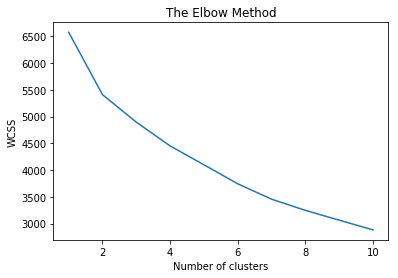

elbow_method - END
('elapsed_time (in seconds): ', 0.7448198795318604)


In [245]:
def find_cluster_number():
    start_time = time.time()
    data = run_load_data()
    data = run_random_replace_data_with_nan(data) # This step is not needed in real problem. Missing data should already be NaN.
    data = run_add_uuid(data) # This step is not needed in real problem. Uuid column should already be included in data.
    k_means_processed_data, uuid = run_k_means_pre_processing(data)
    run_elbow_method(k_means_processed_data)
    #k = 5 is optimal
    print('elapsed_time (in seconds): ', time.time() - start_time)
find_cluster_number()

load_data - START
load_data - END
random_replace_data_with_nan - START
random_replace_data_with_nan - END
k_means_pre_processing - START
k_means_pre_processing - END
k_means_clustering - START
k_means_clustering - END
extract_uuid_and_label - START
extract_uuid_and_label - END
cluster_analytics - START
cluster_label
0     55
1     65
2    269
3    101
4     16
dtype: int64
cluster_analytics - END
xgb_pre_processing - START
xgb_pre_processing - END
train_test_split - START
train_test_split - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   11.4s finished
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.5, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'max_depth': 3})
('Best AUC found: ', 0.9972153465346535)
grid_search - END
cross_validation - START
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.939506      0.044375        0.973828       0.004623
1       0.965741      0.027522        0.986700       0.006721
2       0.961092      0.025830        0.991723       0.005280
3       0.984542      0.008014        0.994468       0.003578
4       0.988091      0.005096        0.994836       0.003128
5       0.987937      0.006779        0.994469       0.003528
6       0.987624      0.004968        0.995214       0.003469
7       0.985776      0.004269        0.995824       0.002060
8       0.983307      0.006095        0.996326       0.001775
9       0.983298      0.006332        0.996346       0.001499
cross-validation model accuracy on train dataset:  0.9832984
cross_validation - END
train_model - STAR

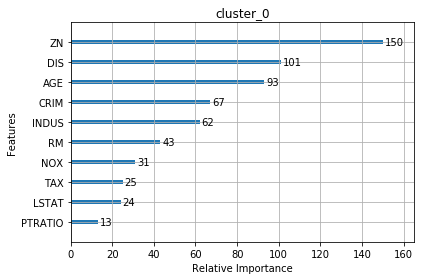

feature_importance - END
train_test_split - START
train_test_split - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   10.1s finished
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.5, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'max_depth': 4})
('Best AUC found: ', 0.9980232882443173)
grid_search - END
cross_validation - START
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.767769      0.069855        0.833487       0.018538
1       0.903662      0.093442        0.924268       0.063822
2       0.918704      0.067976        0.932830       0.053888
3       0.948732      0.051787        0.962235       0.040338
4       0.954929      0.047243        0.964232       0.037733
5       0.964789      0.050547        0.977500       0.024863
6       0.976901      0.031877        0.989612       0.011444
7       0.985634      0.020243        0.997156       0.002446
8       0.984789      0.021050        0.997925       0.001714
9       0.993803      0.010411        0.999268       0.000267
cross-validation model accuracy on train dataset:  0.9938027999999999
cross_validation - END
train_mod

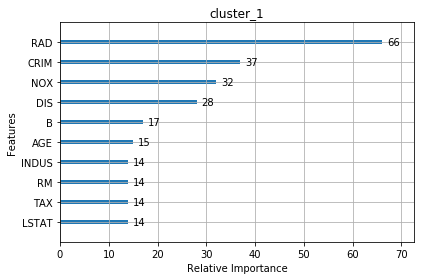

feature_importance - END
train_test_split - START
train_test_split - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   17.5s finished


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'max_depth': 4})
('Best AUC found: ', 0.985318612330319)
grid_search - END
cross_validation - START
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.765980      0.083296        0.824992       0.031404
1       0.842010      0.074920        0.896805       0.030556
2       0.890292      0.062407        0.938419       0.025375
3       0.908902      0.055989        0.955656       0.017249
4       0.918605      0.047326        0.962663       0.010300
5       0.922990      0.043161        0.968739       0.006564
6       0.930386      0.043218        0.971965       0.004660
7       0.944805      0.024967        0.976194       0.004916
8       0.949252      0.023470        0.978068       0.005728
9       0.952668      0.027856        0.981214       0.006006
cross-validation model accuracy on train dataset:  0.9526680000000001
cross_validation - END
train_mo

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


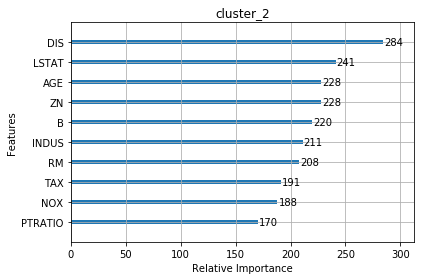

feature_importance - END
train_test_split - START
train_test_split - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   15.5s finished


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 3})
('Best AUC found: ', 0.9881360491818413)
grid_search - END
cross_validation - START
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.794504      0.028005        0.841474       0.018634
1       0.875628      0.039509        0.931016       0.028677
2       0.912410      0.024202        0.955418       0.010814
3       0.940395      0.032757        0.972667       0.013924
4       0.949756      0.018252        0.980422       0.005165
5       0.955583      0.017352        0.981783       0.005249
6       0.954445      0.018655        0.982709       0.005390
7       0.958930      0.019248        0.985495       0.002766
8       0.962155      0.024107        0.986641       0.002879
9       0.961496      0.025834        0.988986       0.001275
cross-validation model accuracy on train dataset:  0.9614958
cross_validation - END
train_model - S

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


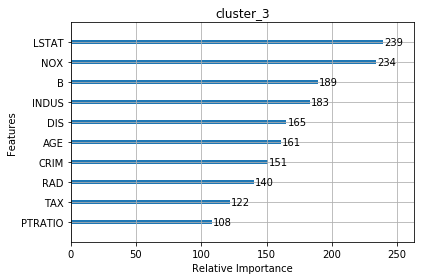

feature_importance - END
train_test_split - START
train_test_split - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    8.8s finished
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.5, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'max_depth': 3})
('Best AUC found: ', 1.0)
grid_search - END
cross_validation - START
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.584615      0.208285        0.663044       0.172235
1       0.685897      0.256859        0.755280       0.201938
2       0.775641      0.274850        0.897589       0.125466
3       1.000000      0.000000        1.000000       0.000000
4       0.997436      0.005128        0.999187       0.001355
5       0.992308      0.010256        0.997793       0.004130
6       0.993590      0.012820        0.998083       0.003834
7       1.000000      0.000000        1.000000       0.000000
8       1.000000      0.000000        1.000000       0.000000
9       1.000000      0.000000        1.000000       0.000000
cross-validation model accuracy on train dataset:  1.0
cross_validation - END
train_model - START
train_model - END
r

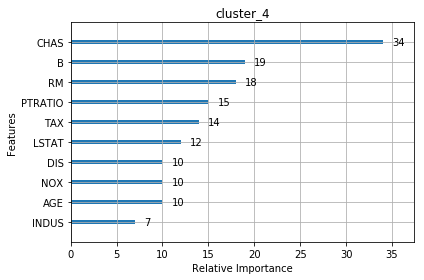

feature_importance - END
('elapsed_time (in seconds): ', 66.12076687812805)


In [255]:
def k_means_clustering():
    cluster_number = 5 # Based on the largest drop in WCSS in previous function
    start_time = time.time()
    data = run_load_data()
    data = run_random_replace_data_with_nan(data) # This step is not needed in real problem. Missing data should already be NaN.
    data = run_add_uuid(data) # This step is not needed in real problem. Uuid column should already be included in data.
    k_means_processed_data, uuid = run_k_means_pre_processing(data)
    k_means_processed_data = run_k_means_clustering(cluster_number, k_means_processed_data, uuid)
    run_extract_uuid_and_label(k_means_processed_data)
    run_cluster_analytics(k_means_processed_data) # To find count of each cluster label
    xgb_processed_data, uuid = run_xgb_pre_processing(data) # re-preprocessing as xgb doesn't need data to be scaled
    run_xgboost_cluster_feature_importance(k_means_processed_data, xgb_processed_data, cluster_number = 0, title ='cluster_0') # Run xgboost feature importance for cluster 0
    run_xgboost_cluster_feature_importance(k_means_processed_data, xgb_processed_data, cluster_number = 1, title ='cluster_1') # Run xgboost feature importance for cluster 1
    run_xgboost_cluster_feature_importance(k_means_processed_data, xgb_processed_data, cluster_number = 2, title ='cluster_2') # Run xgboost feature importance for cluster 2
    run_xgboost_cluster_feature_importance(k_means_processed_data, xgb_processed_data, cluster_number = 3, title ='cluster_3') # Run xgboost feature importance for cluster 3
    run_xgboost_cluster_feature_importance(k_means_processed_data, xgb_processed_data, cluster_number = 4, title ='cluster_4') # Run xgboost feature importance for cluster 4
    print('elapsed_time (in seconds): ', time.time() - start_time)
k_means_clustering()